In [1]:
import json
import matplotlib.pyplot as plt

In [2]:
with open('/home/dsola/repos/PGA-Net/results/val_set/glamorous_breeze_180_small_axial_unet_lbc_ice-mean-iou-epoch.json', 'r') as fp:
    full_axial_lbc_unet_no_reg_iou = json.load(fp)
with open('/home/dsola/repos/PGA-Net/results/val_set/avid_night_179_axial_unet_lbc_ice-mean-iou-epoch.json', 'r') as fp:
    small_axial_lbc_unet_no_reg_iou = json.load(fp)
with open('/home/dsola/repos/PGA-Net/results/val_set/classic_deluge_213_full_axial_lbc_unet_2e-1_weight_decay-mean-iou-epoch.json', 'r') as fp:
    full_axial_lbc_unet_lvl1_reg_iou = json.load(fp)
with open('/home/dsola/repos/PGA-Net/results/val_set/eternal_valley_214_full_axial_lbc_unet_1e-1_weight_decay-mean-iou-epoch.json', 'r') as fp:
    full_axial_lbc_unet_lvl2_reg_iou = json.load(fp)
    
with open('/home/dsola/repos/PGA-Net/results/val_set/glamorous_breeze_180_small_axial_unet_lbc_ice-mean-acc-epoch.json', 'r') as fp:
    full_axial_lbc_unet_no_reg_acc = json.load(fp)
with open('/home/dsola/repos/PGA-Net/results/val_set/avid_night_179_axial_unet_lbc_ice-mean-acc-epoch.json', 'r') as fp:
    small_axial_lbc_unet_no_reg_acc = json.load(fp)
with open('/home/dsola/repos/PGA-Net/results/val_set/classic_deluge_213_full_axial_lbc_unet_2e-1_weight_decay-mean-acc-epoch.json', 'r') as fp:
    full_axial_lbc_unet_lvl1_reg_acc = json.load(fp)
with open('/home/dsola/repos/PGA-Net/results/val_set/eternal_valley_214_full_axial_lbc_unet_1e-1_weight_decay-mean-acc-epoch.json', 'r') as fp:
    full_axial_lbc_unet_lvl2_reg_acc = json.load(fp)

In [3]:
def plot_json(json_dict, name, ax):
    ax.plot(list(json_dict.keys()), list(json_dict.values()), label=name)

No Regularization = weight decay of 1e-8

Level 1 = weight decay of 1e-2

Level 2 = weight decay of 1e-1

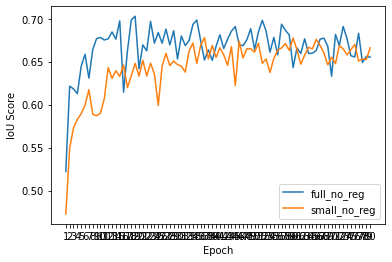

In [4]:
fig, ax = plt.subplots()

ax.set_ylabel('IoU Score')
ax.set_xlabel('Epoch')
plot_json(full_axial_lbc_unet_no_reg_iou, 'full_no_reg', ax)
plot_json(small_axial_lbc_unet_no_reg_iou, 'small_no_reg', ax)
# plot_json(full_axial_lbc_unet_lvl1_reg_iou, 'full_reg_1', ax)
# plot_json(full_axial_lbc_unet_lvl2_reg_iou, 'full_reg_2', ax)
plt.legend();

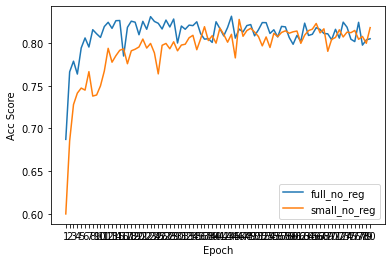

In [5]:
fig, ax = plt.subplots()

ax.set_ylabel('Acc Score')
ax.set_xlabel('Epoch')
plot_json(full_axial_lbc_unet_no_reg_acc, 'full_no_reg', ax)
plot_json(small_axial_lbc_unet_no_reg_acc, 'small_no_reg', ax)
# plot_json(full_axial_lbc_unet_lvl1_reg_acc, 'full_reg_1', ax)
# plot_json(full_axial_lbc_unet_lvl2_reg_acc, 'full_reg_2', ax)
plt.legend();

### Plot examples

When we see "overfitting" it is within the loss function but not the iou or accuracy metrics

Let's plot an example with high loss and high metrics and another with low loss and high metrics to see if there is a visual difference

Avid-night-179 is a full unet and has higher loss than glamorous-breeze-180 which is smaller unet with lower loss.  Difference is most significant at 80 epochs and less significant at 20 epochs

In [2]:
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC, LargeAxialLBC
from src.models.unet.unet_model import UNet
from src.models.dsc.dsc_unet import UNetDSC
import torch
from src.datasets.ice import Ice, IceForVisualizing
import numpy as np
import os
from torch import nn
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
import torch.nn.functional as F
import matplotlib

latex = True
#plotting and colour set ups
if latex:
#     matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
#         'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [43]:
def eval_model(model: nn.Module, checkpoint_path: str, title: str, class_ind=2, second=False) -> None:
    
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.train()
    out = nn.Softmax(dim=1)

    mask_list, pred_list = [], []

    img = val_set[IMG_NUMBER]['image'].to(device=device).unsqueeze(0)
    img_orig = val_set[IMG_NUMBER]['img_orig'].to(device=device)
    mask = val_set[IMG_NUMBER]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        output = model(img)
    sftmx = out(output)
    argmx = torch.argmax(sftmx, dim=1)

    hist = _fast_hist(mask.squeeze(0).squeeze(0), argmx.squeeze(0).to(dtype=torch.long), 3)
    iou = jaccard_index(hist)[0]
    class_ious = jaccard_index(hist)[1]
    acc = per_class_pixel_accuracy(hist)[0]
    loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()
    
    fig, axs = plt.subplots(1, 6, figsize=(20,3))
    img_orig_np = img_orig.permute(0, 2, 1).detach().cpu().numpy()
    axs[0].imshow(np.flipud(np.rot90(img_orig_np)))
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].tick_params(axis=u'both', which=u'both',length=0)
    if second:
        axs[0].set_title('(g) \n Image')
    else:
        axs[0].set_title('(a) \n Image')

    mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[1].imshow(mask_np, cmap='copper')
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    axs[1].tick_params(axis=u'both', which=u'both',length=0)
    if second:
        axs[1].set_title('(h) \n Ground Truth')
    else:
        axs[1].set_title('(b) \n Ground Truth')

    argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
    axs[2].imshow(argmx_np, cmap='copper')
    axs[2].set_xticklabels([])
    axs[2].set_yticklabels([])
    axs[2].tick_params(axis=u'both', which=u'both',length=0)
    if second:
        axs[2].set_title('(i) \n Prediction')
    else:
        axs[2].set_title('(c) \n Prediction')

    sftmx_np = sftmx.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    axs[3].imshow(sftmx_np[:, :, class_ind], cmap='copper')
    axs[3].set_xticklabels([])
    axs[3].set_yticklabels([])
    axs[3].tick_params(axis=u'both', which=u'both',length=0)
    if second:
        axs[3].set_title('(j) \n Softmax Output for \n Frazil Class')
    else:
        axs[3].set_title('(d) \n Softmax Output for \n Frazil Class')

    only_class = np.where((mask_np[:, :, 0]==class_ind), sftmx_np[:, :, class_ind], np.nan)
    axs[4].imshow(only_class, cmap='copper')
    axs[4].set_xticklabels([])
    axs[4].set_yticklabels([])
    axs[4].tick_params(axis=u'both', which=u'both',length=0)
    if second:
        axs[4].set_title('(k) \n Softmax Output for \n Frazil Class where \n Groundtruth is Frazil')
    else:
        axs[4].set_title('(e) \n Softmax Output for \n Frazil Class where \n Groundtruth is Frazil')

    axs[5].hist(only_class, color=['k' for _ in only_class])
    axs[5].set_ylim(0,200)
    if second:
        axs[5].set_title('(l) \n Histogram of Softmax Output \n for Frazil Class where \n Groundtruth is Frazil')
    else:
        axs[5].set_title('(f) \n Histogram of Softmax Output \n for Frazil Class where \n Groundtruth is Frazil')

    class_val = np.mean([-np.log(x + 0.00000000001) for x in only_class.flatten() if not np.isnan(x)])
    class_iou = class_ious[class_ind].item()
    fig.suptitle(title + f"\n mIoU: {iou:.2f}, Mean CE Loss: {loss:.2f}, IoU Frazil: {class_iou:.2f}, CE Loss Frazil: {class_val:.2f}", y=1.3);
    return fig

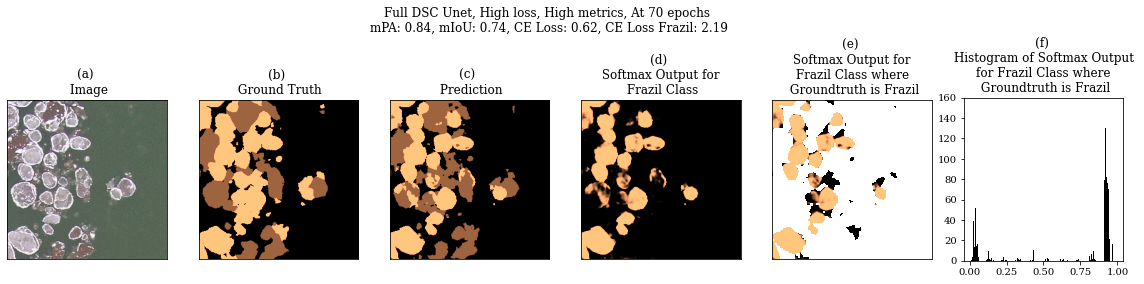

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetDSC(3, 3).to(device)
checkpoint_path = '/home/dsola/repos/PGA-Net/checkpoints/helpful_fire_308_unet_dsc_ice/epoch70.pth'
title = 'Full DSC Unet, High loss, High metrics, At 70 epochs'
class_ind = 2

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.train()
out = nn.Softmax(dim=1)

mask_list, pred_list = [], []

img = val_set[IMG_NUMBER]['image'].to(device=device).unsqueeze(0)
img_orig = val_set[IMG_NUMBER]['img_orig'].to(device=device)
mask = val_set[IMG_NUMBER]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)

with torch.no_grad():
    output = model(img)
sftmx = out(output)
argmx = torch.argmax(sftmx, dim=1)

hist = _fast_hist(mask.squeeze(0).squeeze(0), argmx.squeeze(0).to(dtype=torch.long), 3)
iou = jaccard_index(hist)[0]
acc = per_class_pixel_accuracy(hist)[0]
loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()

fig, axs = plt.subplots(1, 6, figsize=(20,3))
img_orig_np = img_orig.permute(0, 2, 1).detach().cpu().numpy()
axs[0].imshow(np.flipud(np.rot90(img_orig_np)))
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].tick_params(axis=u'both', which=u'both',length=0)
axs[0].set_title('(a) \n Image')

mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
axs[1].imshow(mask_np, cmap='copper')
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[1].tick_params(axis=u'both', which=u'both',length=0)
axs[1].set_title('(b) \n Ground Truth')

argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
axs[2].imshow(argmx_np, cmap='copper')
axs[2].set_xticklabels([])
axs[2].set_yticklabels([])
axs[2].tick_params(axis=u'both', which=u'both',length=0)
axs[2].set_title('(c) \n Prediction')

sftmx_np = sftmx.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
axs[3].imshow(sftmx_np[:, :, class_ind], cmap='copper')
axs[3].set_xticklabels([])
axs[3].set_yticklabels([])
axs[3].tick_params(axis=u'both', which=u'both',length=0)
axs[3].set_title('(d) \n Softmax Output for \n Frazil Class')

only_class = np.where((mask_np[:, :, 0]==class_ind), sftmx_np[:, :, class_ind], np.nan)
axs[4].imshow(only_class, cmap='copper')
axs[4].set_xticklabels([])
axs[4].set_yticklabels([])
axs[4].tick_params(axis=u'both', which=u'both',length=0)
axs[4].set_title('(e) \n Softmax Output for \n Frazil Class where \n Groundtruth is Frazil')

axs[5].hist(only_class, color=['k' for _ in only_class])
axs[5].set_ylim(0,160)
axs[5].set_title('(f) \n Histogram of Softmax Output \n for Frazil Class where \n Groundtruth is Frazil')

class_val = np.mean([-np.log(x + 0.00000000001) for x in only_class.flatten() if not np.isnan(x)])
fig.suptitle(title + f"\n mPA: {acc:.2f}, mIoU: {iou:.2f}, CE Loss: {loss:.2f}, CE Loss Frazil: {class_val:.2f}", y=1.3);

In [10]:
jaccard_index(hist)[1][0].item()

0.9426637887954712

In [21]:
np.min([x for x in only_class.flatten() if not np.isnan(x)])

5.3616583e-10

### Validataion Data

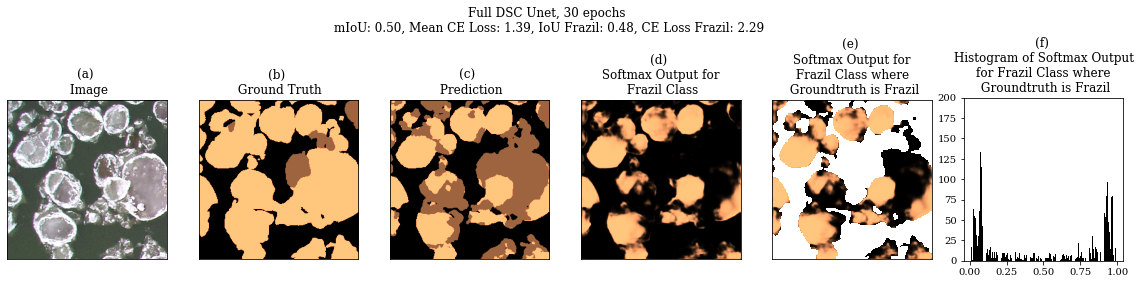

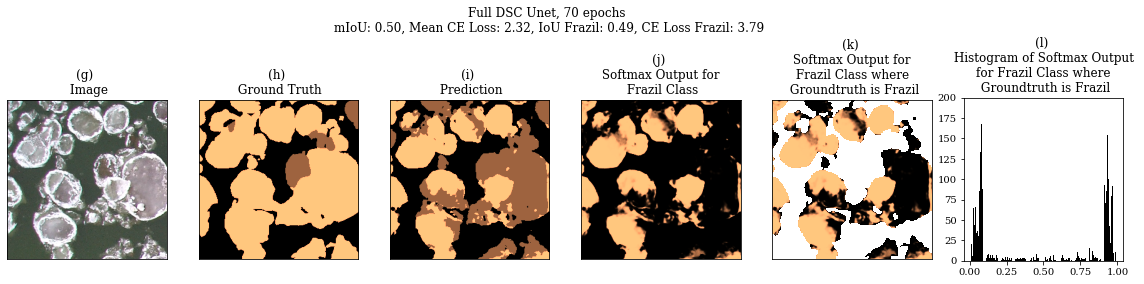

In [44]:
IMG_NUMBER = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_crop = 256
img_scale = 0.35
class_ind =  2

val_set = IceForVisualizing(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

fig1 = eval_model(
    UNetDSC(3, 3).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/helpful_fire_308_unet_dsc_ice/epoch30.pth', 
    'Full DSC Unet, 30 epochs',
    class_ind=class_ind
)
fig2 = eval_model(
    UNetDSC(3, 3).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/helpful_fire_308_unet_dsc_ice/epoch70.pth', 
    'Full DSC Unet, 70 epochs',
    class_ind=class_ind, second=True
)

# eval_model(
#     AxialUNetLBC(3, 3, 10).to(device), 
#     '/home/dsola/repos/PGA-Net/checkpoints/avid_night_179_axial_unet_lbc_ice/epoch15.pth', 
#     'Full Unet, high loss, high metrics, 15 epochs'
# )
# eval_model(
#     SmallAxialUNetLBC(3, 3, 10).to(device), 
#     '/home/dsola/repos/PGA-Net/checkpoints/glamorous_breeze_180_small_axial_unet_lbc_ice/epoch15.pth', 
#     'Small Unet, low loss, high metrics, 15 epochs'
# )

In [46]:
# fig1.savefig("../images/overfitting1.svg", format='svg', dpi=1200)

### Observations

* Cross entropy vs IoU loss: https://stats.stackexchange.com/questions/321460/dice-coefficient-loss-function-vs-cross-entropy

* Good explanation of cross entropy: https://www.youtube.com/watch?v=6ArSys5qHAU

* Smaller UNet has much better defined borders than larger UNet

* The fact that a viually small change in the predictions produces a large change in cross entropy suggests that the softmax output is somewhat ambiguous (closer to zero on the -log(x) graph), however, since these don't produce a large change in IoU and Accuracy metrics, the argmax function disregards this ambiguity as the probabilities are still close to the right class.

* This is visible in the softmax plots.  We can see more intermediate values in between zero and 1, less in the extremes (visible in a heatmap or a histogram)

* To see the effect of regularization, view the plots on WandB (classic_deluge_213: minor reg, eternal_valley_214: more reg)

### Training Data

We should not see the same discrepancy as the data is "overfit" to the training therefrore training results should all be great for the full UNet

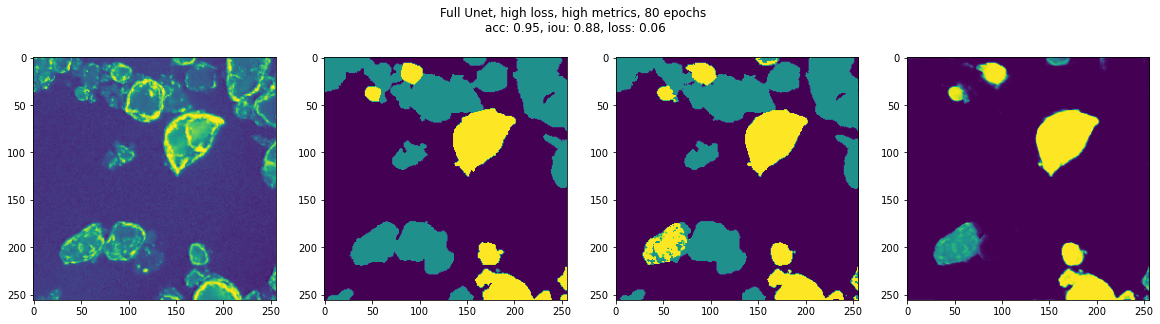

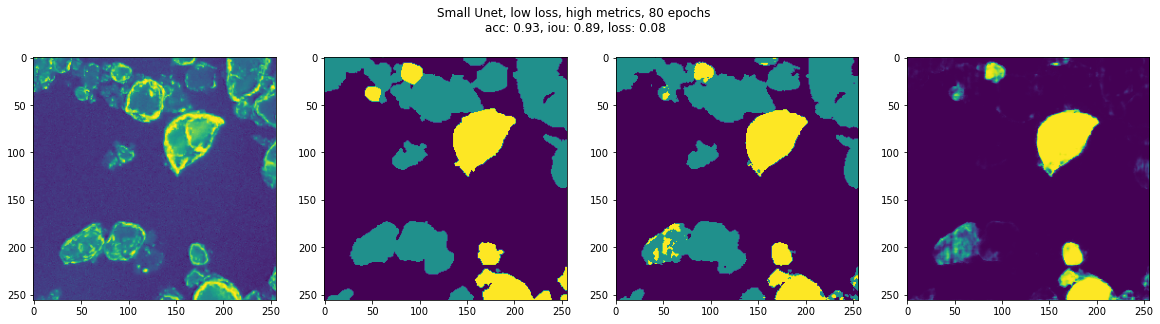

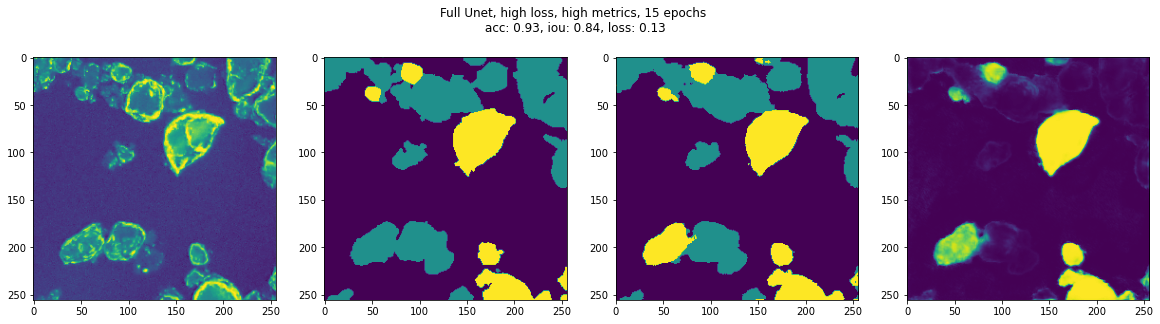

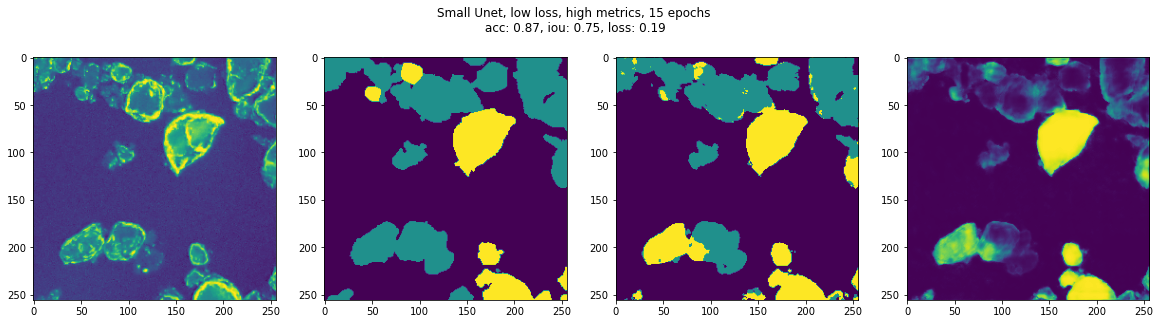

In [32]:
IMG_NUMBER = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_crop = 256
img_scale = 0.35

val_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'train', img_scale, img_crop)

eval_model(
    AxialUNetLBC(3, 3, 10).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/avid_night_179_axial_unet_lbc_ice/epoch80.pth', 
    'Full Unet, high loss, high metrics, 80 epochs'
)
eval_model(
    SmallAxialUNetLBC(3, 3, 10).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/glamorous_breeze_180_small_axial_unet_lbc_ice/epoch80.pth', 
    'Small Unet, low loss, high metrics, 80 epochs'
)
eval_model(
    AxialUNetLBC(3, 3, 10).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/avid_night_179_axial_unet_lbc_ice/epoch15.pth', 
    'Full Unet, high loss, high metrics, 15 epochs'
)
eval_model(
    SmallAxialUNetLBC(3, 3, 10).to(device), 
    '/home/dsola/repos/PGA-Net/checkpoints/glamorous_breeze_180_small_axial_unet_lbc_ice/epoch15.pth', 
    'Small Unet, low loss, high metrics, 15 epochs'
)